# Imports and data prep

In [1]:
%%capture
# installing and loading all needed modules

#!pip install pytorch-forecasting
#!pip install pytorch-forecasting[mqf2]
#!pip install wget
#!pip install pyunpack
#!pip install optuna

# install ai based autocomplete
#!pip3 install jupyter-tabnine --user
#!jupyter nbextension install --py jupyter_tabnine --user
#!jupyter nbextension enable --py jupyter_tabnine --user
#!jupyter serverextension enable --py jupyter_tabnine --user


import sys
import optuna
import wget
import os
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
import pickle
import tensorflow as tf
import tensorboard as tb
import time

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data.examples import get_stallion_data
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from pyunpack import Archive

# run to prevent compatibilty issues with tensorflow/tensorboard/pytorch
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

#from google.colab import drive
#drive.mount('/content/drive')

from dataloading_helpers import electricity_dataloader, dax_dataloader #,retail_dataloader, walmart_dataloader, 
from config import *

In [36]:
#log_folder = '/content/drive/MyDrive/data/electricity/lightning_logs/version_0'

#writer = SummaryWriter(log_folder)
#%tensorboard --logdir=log_folder
#%reload_ext tensorboard
#%reload_ext tensorboard
#%tensorboard --logdir=log_folder

False

# Training

In [2]:
stocks = dax_dataloader.create_stocks_timeseries()

timeseries_dict =  stocks
config_name_string = "stocks"
parameters = []

In [2]:
electricity = electricity_dataloader.create_electricity_timeseries()

timeseries_dict =  electricity
config_name_string = "electricity"
parameters = []

In [3]:
if torch.cuda.is_available():
    accelerator = "gpu"
    devices = torch.cuda.current_device()
else:
    accelerator = None
    devices = None

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
#logger = TensorBoardLogger("/content/drive/MyDrive/data/electricity")  # logging results to a tensorboard

model_dir = CONFIG_DICT["models"][config_name_string]

trainer = pl.Trainer(
    default_root_dir=model_dir,
    max_epochs=5,
    accelerator=accelerator,
    devices=devices,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    log_every_n_steps=1
    #logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    timeseries_dict["training_dataset"],
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=1,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


# fit network
trainer.fit(
    tft,
    train_dataloaders=timeseries_dict["train_dataloader"],
    val_dataloaders=timeseries_dict["val_dataloader"],
)

print("trainging done.")

C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


Number of parameters in network: 41.4k


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Benedikt\anaconda_main\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

trainging done.


In [ ]:
t0 = time.time()

# evaluate
best_model_path = trainer.checkpoint_callback.best_model_path
t1 = time.time()
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
t2 = time.time()
actuals = torch.cat([y[0] for x, y in iter(timeseries_dict["val_dataloader"])])
t3 = time.time()
predictions = best_tft.predict(timeseries_dict["val_dataloader"])
print("Best model MAE: ",(actuals - predictions).abs().mean().item())
print(t1-t0, t2-t1, t3-t2, t4-t3, t5-t4)

  # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(timeseries_dict["val_dataloader"])])
t4 = time.time()
baseline_predictions = Baseline().predict(timeseries_dict["val_dataloader"])
print("Baseline MAE: ",(actuals - baseline_predictions).abs().mean().item(), "\n\n")

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
print("Plotting attention, actuals and predictions:\n")
t4 = time.time()
raw_predictions, x = best_tft.predict(timeseries_dict["val_dataloader"], mode="raw", return_x=True)

for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
t5 = time.time()
    
    

print("time", t1-t0, t2-t1, t3-t2, t4-t3, t5-t4)

In [ ]:
best_tft.hparams.batch_size

# Hyperparameters

In [ ]:
'''
still needs implementation, look here for error:
https://stackoverflow.com/questions/74157157/pytorch-lightning-got-an-unexpected-keyword-argument-weights-summary


needed to implement hyper optimization of QuantileLoss():
from torchmetrics.utilities import check_forward_full_state_property
check_forward_full_state_property


Parameter range used in Google paper:

state_size = [10, 20, 40, 80, 160, 240, 320]
dropout_rate =  [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
minibatch_size = [64, 128, 256]
learning_rate = [0.0001, 0.001, 0.01]
ma_gradient_norm = [0.01, 1.0, 100.0]
num_heads = [1, 2, 3, 4]

'''

# create study
study = optimize_hyperparameters(
    electricity_datasets['train_dataloader'],
    electricity_datasets["val_dataloader"],
    model_path="hyper_tuning",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(10, 320),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

KeyError: ignored

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'decoder_variables': <Figure size 504x270 with 1 Axes>}

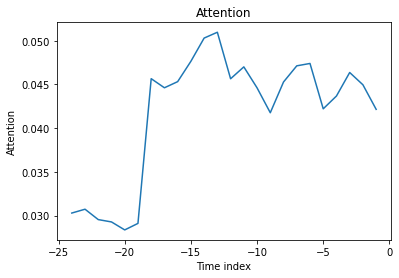

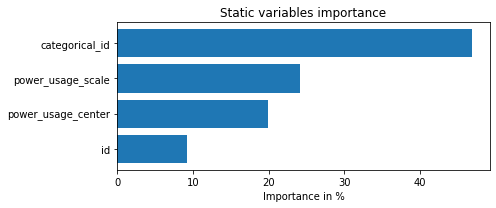

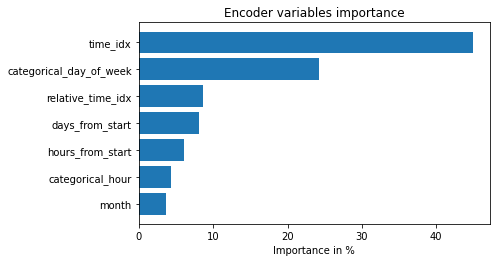

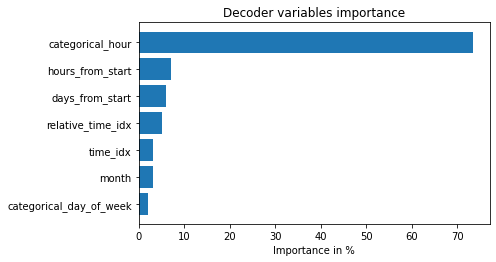

In [ ]:
#interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
#best_tft.plot_interpretation(interpretation)